# Lecture worksheet 21 Solutions

The next two cells are duplicated from the notes for your convenience.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

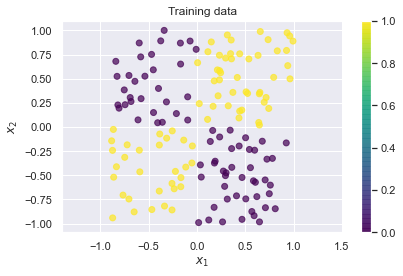

In [5]:
### This cell is exactly the same as the version from the notes
N_test = 500
N_train = 150

np.random.seed(2021)

# Create a training dataset
x1_train = np.random.uniform(-1, 1, N_train)
x2_train = np.random.uniform(-1, 1, N_train)

y_train = (x1_train * x2_train > 0).astype(np.int64)


# Create a feature matrix that we can use for classification
X_train = np.vstack([x1_train, x2_train]).transpose()


# Create a test dataset
x1_test = np.random.uniform(-3, 3, N_test)
x2_test = np.random.uniform(-3, 3, N_test)

y_test = (x1_test * x2_test > 0).astype(np.int64)


# Create a feature matrix that we can use to evaluate
X_test = np.vstack([x1_test, x2_test]).transpose()

def draw_results(x1, x2, color, plot_title=''):
    plt.figure()
    plt.scatter(x1, x2, c=color, cmap='viridis', alpha=0.7);
    plt.colorbar()
    plt.title(plot_title)
    plt.axis('equal')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.tight_layout()
    
draw_results(
    x1_train, x2_train, color=y_train,
    plot_title="Training data"
)

## Question 1

### Q1.1 Fill-in-the-blank

For each of the following, fill in the blank. Try to keep your answers as specific as possible.

(a) Backpropagation is an efficient way of computing **gradients**.

(b) At each layer of a neural network (except the last), we apply a **nonlinear** function.

*Note: in many cases (e.g., classification, we apply a nonlinear function such as a sigmoid after the last layer, too)*

(c) Interpretability (and/or explainability) is especially important in cases where **the decisions are high-stakes**.

## Question 2: Backpropagation and Neural Nets

### Q2.1 Backpropagation and sigmoids

Most modern-day implementations of neural networks avoid using sigmoid functions for the nonlinearity, and instead favor functions like the **RE**stricted **L**inear **U**nit, aka ReLU (both functions are shown below). One of the main reasons is that when using the sigmoid, the gradient entries often end up being 0: this is called the **vanishing gradient problem**.

(a) Why would the sigmoid often lead to gradient values of 0 when using backpropagation? *Hint: what happens to the derivative for each of these two functions as the input gets large?*

**SOLUTION**: For values of its input far away from 0 (positive *or* negative), the sigmoid function is very flat: this means that its derivative is close to 0. Since backpropagation (/ chain rule) multiplies all the derivatives together, as soon as we have one zero value in our computation graph, everything before it will get multiplied by 0.

(b) When optimizing, why is it bad for the gradient values to be 0?

**SOLUTION**: Gradient values of 0 mean that we don't change our parameters during gradient descent, which means that we can't move toward an optimum.

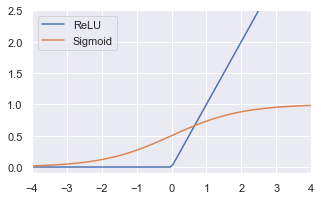

In [2]:
# This cell plots two different nonlinearities used in neural networks:
# The restricted linear unit (ReLU) and the sigmoid
f, ax = plt.subplots(1, 1, figsize=(5, 3))

x = np.linspace(-4, 4, 100)
relu = np.fmax(x, 0)
sigmoid = 1/(1 + np.exp(-x))
ax.plot(x, relu, label='ReLU')
ax.plot(x, sigmoid, label='Sigmoid')
ax.axis([-4, 4, -0.1, 2.5])

ax.legend()

### Q2.2 Implementing a neural network

The following code implements a two-layer neural network. Read over it and try to understand as much of it as you can, then answer the questions below.

In [ ]:
## First cell: set up the data and define the model

import torch
from torch.nn import Sequential, Linear, ReLU
from torch import sigmoid

# The .float() at the end converts to an internal representation
# that pytorch can work with (32-bit floating point number)
X_pt = torch.from_numpy(X_train).float()
y_pt = torch.from_numpy(y_train[:, np.newaxis]).float()

# Remember that the first layer of the neural network generates features.
# This parameter controls how many features get generated.
nn_layer_size = 5

# Sequential models apply component to the input, one after the other
two_layer_classification_nn = Sequential(
    Linear(2, nn_layer_size),
    ReLU(),
    Linear(nn_layer_size, 1),
)
two_layer_classification_nn

In [ ]:
## Second cell: run gradient descent

from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss  # BCE stands for "Binary Cross Entropy"

# The optimizer takes care of taking steps in the direction of the gradient
# for all the parameters in the model. So, we need to tell it what the parameters
# are:
optimizer = SGD(two_layer_classification_nn.parameters(), lr=0.1)
loss_function = BCEWithLogitsLoss()

# One round of training on the entire dataset is called an "epoch".
previous_loss = np.inf
for epoch in range(5000):
    # First, zero out the gradients:
    optimizer.zero_grad()

    # Next, we run the model 'forward' to compute the predictions
    # and then the loss.

    # The first time this code is run (epoch=0), pytorch builds the computation
    # graph behind the scenes, and then reuses it on subsequent iterations.
    predictions = two_layer_classification_nn.forward(X_pt)
    loss = loss_function(predictions, y_pt)
    
    # Next, we compute the gradients using .backward()
    loss.backward()
    
    # Finally, we can run one step of gradient descent:
    optimizer.step()
    if epoch % 500 == 0:
        # Before we print out the loss, we use .detach().numpy(), which is how we convert
        # pytorch tensors (assuming they're part of a computation graph) to numpy arrays.
        
        # The .detach() part creates a copy that's disconnected from the computation graph.
        print("Epoch:", epoch, " | Loss:", loss.detach().numpy())

(a) Use the `predictions` variable and the `draw_results` helper function to visualize the neural net results (predicted probabilities) on the **training set** (the same way we plotted the results from the other models in the notes). 

*Hint: before the `predictions` tensor can be visualized, you'll need to do a few things to it. All the code you need is either imported or demonstrated in the two cells above.*

In [ ]:
# We need to convert to a numpy array, but before we can do that
# we have to detach the tensor from the computation graph (just like we
# did before printing the loss above)
draw_results(x1_train, x2_train, sigmoid(predictions.detach()).numpy())

(b) Now visualize the results (predicted probabilities) on the test set. What do you observe?

In [ ]:
# We need to compute the loss on the test set. First, we convert
# X_test into a pytorch tensor:
X_test_pt = torch.from_numpy(X_test).float()

# Then, we run the neural net to get logits (values between -inf and inf)
y_test_prediction = two_layer_classification_nn.forward(X_test_pt).detach()

# We need to convert the logits to probabilities before visualizing
draw_results(x1_test, x2_test, sigmoid(y_test_prediction).numpy())

# The results are quite good: the model has learned the checkerboard pattern well.

(b) Change the learning rate to 0.001, and rerun **all four cells** above (model/data setup, training, and train/test visualization). How do the results change? Why?

**SOLUTION**: Change `lr=0.1` to `lr=0.001` on line 9 of the "run gradient descent" cell above. With such a small learning rate, the steps we take are much too small. So, the solution is not very good.

(c) Repeat part (b), but for a learning rate of 10.0.

**SOLUTION**: With such a large learning rate, the steps we take are much too big: we take large steps back and forth in the parameter space, and can't settle on an optimal value.

(d) A recent paper suggested using the so-called "swish" or "SiLU" (sigmoid linear unit) nonlinearity ($f(x) = x \cdot \sigma(x)$) instead of ReLU ($f(x) = \text{max}(0, x)$). How would you modify the code above to use this? Be specific.

*Hint: the function is already implemented in pytorch.*

## Question 3

### Q3.1

Suppose we use linear regression trying to predict a complex, nonlinear function of six features. Describe something you can do that will both (a) significantly increase training set accuracy, and (b) significantly decrease interpretability.

**SOLUTION**: One way is to add a large number (>100) of features, each of which is an arbitrary nonlinear combination of the original six. We can likely do a better job of fitting the training set, but we have far more coefficients, each of which corresponds to an arbitrary nonlinear combination that we'll struggle to interpret.

Doing it this way is also likely to overfit to the training set, and could even increase error on a test set!

### Q3.2

(a) Use logistic regression to fit the checkerboard toy dataset, but add one additional feature: the product of $x_1$ and $x_2$. How well does this model do?

Accuracy on test set: 0.994


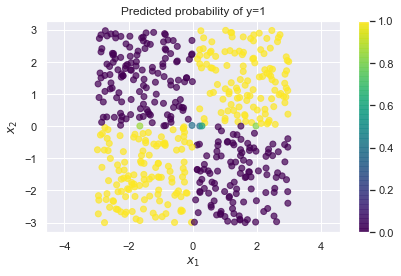

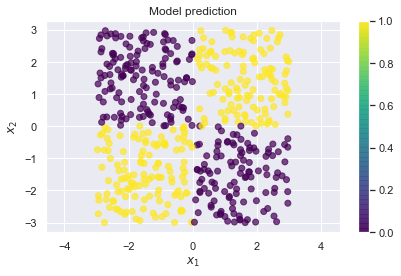

In [8]:
# Most of this code is copy-pasted from the notes.
from sklearn.linear_model import LogisticRegression

new_feat_train = x1_train * x2_train

### SOLUTION: Add the new feature
X_train_new = np.vstack([x1_train, x2_train, x1_train * x2_train]).transpose()
X_test_new = np.vstack([x1_test, x2_test, x1_test * x2_test]).transpose()
###

# Create and fit a scikit-learn logistic regression model on training set
model_logistic = LogisticRegression(penalty='none', solver='lbfgs')
model_logistic.fit(X_train_new, y_train)

# Use the model to predict on the test set
probs = model_logistic.predict_proba(X_test_new)[:, 1]
y_hat = (probs > 0.5).astype(np.int64)


# Visualize the results
draw_results(
    x1_test, x2_test, color=probs, 
    plot_title="Predicted probability of y=1"
)

draw_results(
    x1_test, x2_test, color=y_hat, 
    plot_title="Model prediction"
)

accuracy = np.mean(y_test == y_hat)
print(f"Accuracy on test set: {accuracy}")

In [ ]:
model_logistic.coef_

(b) How would you interpret the coefficients from the model?

**SOLUTION**: The first two coefficients are relatively close to 0, but the third coefficient is *very* large. This means that $x_1x_2$ is the most important feature (out of the three we used) in determining $y$. The sign is positive, so positive values of $x_1x_2$ push the model towards predicting 1, while negative values of $x_1x_2$ push the model toward predicting 0.